In [1]:
import os
import json
import requests
import pandas as pd
import geopandas as gpd
os.environ['USE_PYGEOS'] = '0'
import folium
import folium.plugins
import seaborn as sns
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import branca.colormap as cm
from folium import TileLayer 
from pystac_client import Client
from pystac import Item
from datetime import datetime
import stackstac
import xarray as xr
import rioxarray as rxr
from cartopy import crs as ccrs
import cartopy.feature as cf
import stackstac
import contextily as cx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [2]:
os.chdir('/home/jovyan/embell/portal2.0_maps/Vulcan/')

In [3]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection
# Name of the collection for wetland methane monthly emissions 
collection_name = "vulcan-ffco2-yeargrid-v4"

In [4]:
# Fetching the collection from STAC collections using appropriate endpoint
# Using the Client module of pystac_client

catalog = Client.open(STAC_API_URL)

# Pick the collection
# Select GRA2PES collection: browse item_assets, spatial and temporal extent
collection = catalog.get_collection(collection_name)
collection

<CollectionClient id=vulcan-ffco2-yeargrid-v4>

In [5]:
for collection in catalog.get_collections():
    if 'vulcan' in collection.id:
        print(collection.id)

vulcan-ffco2-elc-res-yeargrid-v4
vulcan-ffco2-yeargrid-v4


In [6]:
catalog.get_collection('vulcan-ffco2-elc-res-yeargrid-v4')

<CollectionClient id=vulcan-ffco2-elc-res-yeargrid-v4>

In [7]:
items = list(collection.get_items())

In [8]:
# Get raw item data without creating Item objects
search = catalog.search(collections=[collection_name])
raw_items = list(search.items_as_dicts())

# Check the first few items for missing hrefs
for i, item in enumerate(raw_items[:3]):  # Check first 3 items
    print(f"Item {i}:")
    for asset_key, asset_data in item.get('assets', {}).items():
        if 'href' not in asset_data:
            print(f"  Asset '{asset_key}' missing href: {asset_data}")
        else:
            print(f"  Asset '{asset_key}' has href: {asset_data['href']}")
    print()

Item 0:
  Asset 'air-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/AIR_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'cmt-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/CMT_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'cmv-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/CMV_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'com-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/COM_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'elc-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/ELC_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'ind-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/IND_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'nrd-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/NRD_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'onr-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/ONR_CO2_USA_mosaic_grid_1km_mn_2021.tif
  Asset 'res-co2' has href: s3://ghgc-data-store/vulcan-ffco2-yeargrid-v4/RES_CO

In [9]:
def has_valid_assets(item_dict):
    """Check if all assets have required href field"""
    assets = item_dict.get('assets', {})
    return all('href' in asset for asset in assets.values())

# Filter items with valid assets only
valid_items = []
for item_dict in search.items_as_dicts():
    if has_valid_assets(item_dict):
        valid_items.append(Item.from_dict(item_dict, root=catalog))
    else:
        print(f"Skipping item {item_dict.get('id', 'unknown')} - invalid assets")

print(f"Found {len(valid_items)} valid items out of total items")

Skipping item vulcan-ffco2-yeargrid-v4-2021 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2020 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2019 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2018 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2017 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2016 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2015 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2014 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2013 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2012 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2011 - invalid assets
Skipping item vulcan-ffco2-yeargrid-v4-2010 - invalid assets
Found 0 valid items out of total items


In [10]:

def clean_item_assets(item_dict):
    """Remove assets that don't have required href field"""
    if 'assets' not in item_dict:
        return item_dict
    
    cleaned_assets = {}
    removed_assets = []
    
    for asset_key, asset_data in item_dict['assets'].items():
        if 'href' in asset_data:
            cleaned_assets[asset_key] = asset_data
        else:
            removed_assets.append(asset_key)
    
    # Update the item dict with cleaned assets
    item_dict['assets'] = cleaned_assets
    
    if removed_assets:
        print(f"Item {item_dict.get('id', 'unknown')}: Removed assets {removed_assets}")
    
    return item_dict

# Process all items with asset cleaning
items = []
for item_dict in catalog.search(collections=[collection_name]).items_as_dicts():
    cleaned_item_dict = clean_item_assets(item_dict)
    item = Item.from_dict(cleaned_item_dict, root=catalog)
    items.append(item)

print(f"Successfully loaded {len(items)} items with cleaned assets")

Item vulcan-ffco2-yeargrid-v4-2021: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2020: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2019: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2018: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2017: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2016: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2015: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2014: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2013: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2012: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2011: Removed assets ['cog_default']
Item vulcan-ffco2-yeargrid-v4-2010: Removed assets ['cog_default']
Successfully loaded 12 items with cleaned assets


In [11]:
ds = stackstac.stack(items,epsg=4326).squeeze()

In [12]:
ds

<xarray.DataArray 'stackstac-d7e41bfba63e6d85ad41e765b834d02f' (time: 12,
                                                                band: 11,
                                                                y: 2650, x: 5832)> Size: 16GB
dask.array<fetch_raster_window, shape=(12, 11, 2650, 5832), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time            (time) datetime64[ns] 96B NaT NaT NaT NaT ... NaT NaT NaT
    id              (time) <U29 1kB 'vulcan-ffco2-yeargrid-v4-2021' ... 'vulc...
  * band            (band) <U9 396B 'air-co2' 'cmt-co2' ... 'total-co2'
  * x               (x) float64 47kB -128.2 -128.2 -128.2 ... -65.32 -65.31
  * y               (y) float64 21kB 51.45 51.44 51.43 ... 22.89 22.88 22.86
    end_datetime    (time) <U25 1kB '2021-12-31T00:00:00+00:00' ... '2010-12-...
    ...              ...
    proj:projjson   object 8B {'id': {'code': 4326, 'authority': 'EPSG'}, 'na...
    proj:code       <U9 36B 'EPSG:4326'
    proj:wkt2       <U302 1kB 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...
    proj:transform  object 8B {0.0, 1.0, -128.22654896758996, 0.0107901521132...
    description     (band) object 88B None ... 'Estimated total annual CO₂ em...
    epsg            int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-128.23016771442616, 22.853...
    crs:            epsg:4326
    transform:      | 0.01, 0.00,-128.23|\n| 0.00,-0.01, 51.45|\n| 0.00, 0.00...
    resolution_xy:  (0.010790152113297388, 0.01079015211329739)

In [13]:
ds['start_datetime']

<xarray.DataArray 'start_datetime' (time: 12)> Size: 1kB
array(['2021-01-01T00:00:00+00:00', '2020-01-01T00:00:00+00:00',
       '2019-01-01T00:00:00+00:00', '2018-01-01T00:00:00+00:00',
       '2017-01-01T00:00:00+00:00', '2016-01-01T00:00:00+00:00',
       '2015-01-01T00:00:00+00:00', '2014-01-01T00:00:00+00:00',
       '2013-01-01T00:00:00+00:00', '2012-01-01T00:00:00+00:00',
       '2011-01-01T00:00:00+00:00', '2010-01-01T00:00:00+00:00'],
      dtype='<U25')
Coordinates:
  * time            (time) datetime64[ns] 96B NaT NaT NaT NaT ... NaT NaT NaT
    id              (time) <U29 1kB 'vulcan-ffco2-yeargrid-v4-2021' ... 'vulc...
    end_datetime    (time) <U25 1kB '2021-12-31T00:00:00+00:00' ... '2010-12-...
    start_datetime  (time) <U25 1kB '2021-01-01T00:00:00+00:00' ... '2010-01-...
    proj:geometry   object 8B {'type': 'Polygon', 'coordinates': [[[-128.2265...
    proj:bbox       object 8B {-128.22654896758996, 51.44087947724907, 22.857...
    proj:shape      object 8B {2649, 5831}
    proj:projjson   object 8B {'id': {'code': 4326, 'authority': 'EPSG'}, 'na...
    proj:code       <U9 36B 'EPSG:4326'
    proj:wkt2       <U302 1kB 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...
    proj:transform  object 8B {0.0, 1.0, -128.22654896758996, 0.0107901521132...
    epsg            int64 8B 4326

In [14]:
# Select variable of interest
var = 'ind-co2'
ds.sel(band=var)['start_datetime']
# Select datetime of interest
dt = '2021-01-01T00:00:00+00:00'
ds_sub = ds.sel(band=var)
del ds

In [15]:
ds_sub = ds_sub[ds_sub['start_datetime'] == dt]

In [16]:
# Loading a shapefile for visualization
shape = gpd.read_file('../cb_2024_us_nation_5m/cb_2024_us_nation_5m.shp').to_crs(4326)

In [17]:
# Loading some city information for extra context
cities = gpd.read_file('../Top50_ACS_2021_5YR_PLACE_VulcPrj_Pop.gpkg').to_crs(4326)

In [18]:
cities['INTPTLAT'] = pd.to_numeric(cities['INTPTLAT'], errors='coerce')
cities['INTPTLON'] = pd.to_numeric(cities['INTPTLON'], errors='coerce')

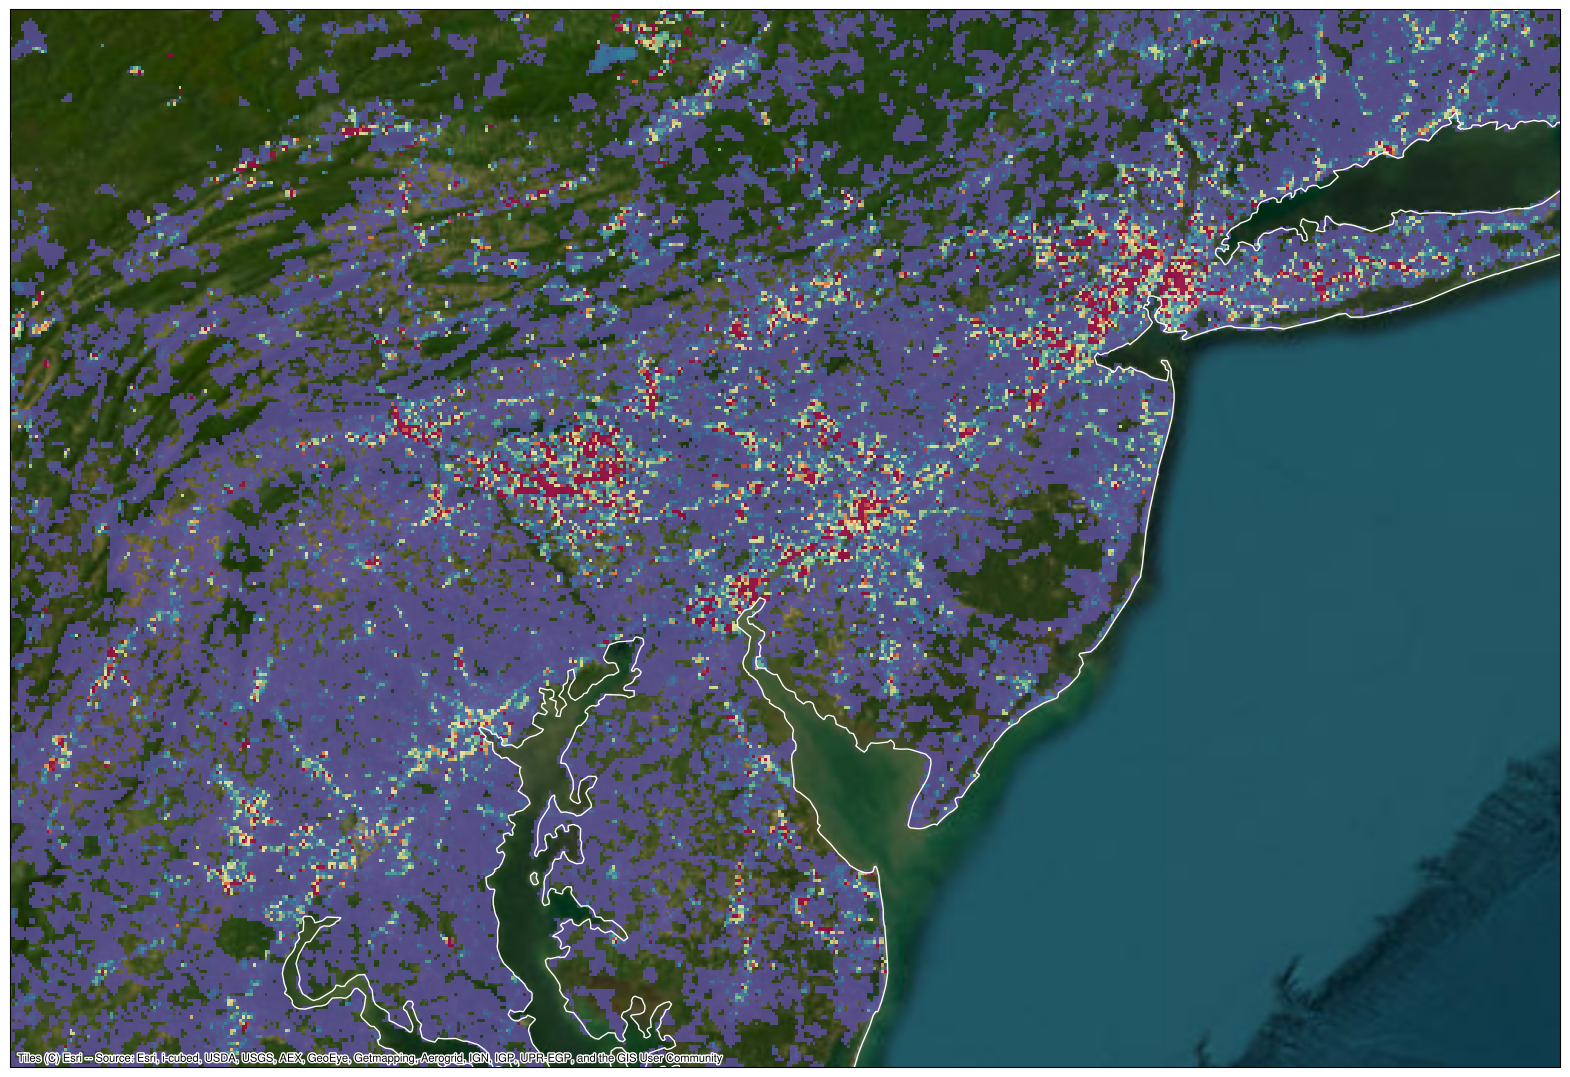

In [23]:
plt.close('all')
add_legend = False
add_shape = True
add_placenames = False

cbar_range = [0,np.nanmean(ds_sub.values)+0.15*np.nanstd(ds_sub.values)]

aoi_name='Eastern Seaboard'
bounds = {'CONUS':[-135,23,-59,52],
        'Northeast':[-83.4,38.39,-66.5,48.36],
          'Eastern Seaboard':[-78.35,38.14,-72.52,41.64]
        }

# colorbar formatting arguments
cbar_args = {'shrink':0.5,'orientation':'horizontal','aspect':12}

# font formatting
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Nimbus Sans','DejaVu Sans']

# Start generating a map
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_ylim(bounds[aoi_name][1],bounds[aoi_name][3])
ax.set_xlim(bounds[aoi_name][0],bounds[aoi_name][2])

# Basemap
cx.add_basemap(ax,crs=ccrs.PlateCarree(),source=cx.providers.Esri.WorldImagery)#source=cx.providers.Esri.WorldTerrain)
# Data layer
pl = ds_sub.plot(ax=ax,cmap='Spectral_r',vmin=cbar_range[0],vmax=cbar_range[1],alpha=0.8,add_colorbar=False)
ax.set_title('')

# Add AOI outline if desired
if add_shape:
    try:
        shape.plot(ax=ax,facecolor='none',edgecolor='white',linewidth=1)
    except:
        print('No shape to add')
        
# Add legend
if add_legend:
    ax_ins = ax.inset_axes([0.76,0.05,0.2,0.02],transform=ax.transAxes)
    # Create a white rectangle larger than the colorbar
    pos = ax_ins.get_position()
    rect = patches.Rectangle((pos.x0-0.033, pos.y0-0.02), 
                pos.width+0.055, pos.height+0.05,
                edgecolor='white', 
                facecolor='white', transform=fig.transFigure,
                alpha=0.8,zorder=1)

    ax.add_patch(rect)
    cb = fig.colorbar(pl,cax=ax_ins,orientation="horizontal",
                    extend='max')
   
    cb.ax.xaxis.set_label_position('top')
    cb.set_label(f'{dt[0:4]} Vulcan v4.0 Industrial Fossil CO$_2$ Emissions\n(tonne CO$_2$/km$^2$/year)',
                 fontweight='bold',fontsize=12,labelpad=10
                )
    ax_ins.set_zorder(100)

# Add city names
if add_placenames:
    for idx, row in cities.iterrows():
        inlon = bounds[aoi_name][0]< row['INTPTLON'] < bounds[aoi_name][2]
        inlat = bounds[aoi_name][1] < row['INTPTLAT'] < bounds[aoi_name][3]
        if inlon and inlat:
            ax.annotate(row['NAME'],   # Replace with your column names
                xy=(row['INTPTLON'], row['INTPTLAT']),
                xytext=(25,-25), # Offset from the actual point location
                textcoords='offset points',
                ha='right', va='center',
                fontsize=14,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='white', alpha=0.8),
                transform=ccrs.PlateCarree())

plt.show()

In [24]:
savename = f'Vulcan_v4_{var}_{dt[0:4]}_{aoi_name.replace(' ','_')}.png'
if add_legend:
    savename = savename.replace('.png','_legend.png')
if add_shape:
    savename = savename.replace('.png','_shape.png')
if add_placenames:
    savename = savename.replace('.png','_placenames.png')
fig.savefig(savename,dpi=300,bbox_inches='tight')
print(f'File saved as {savename}.')

File saved as Vulcan_v4_ind-co2_2021_Eastern_Seaboard_shape.png.


In [18]:
np.nanmean(ds_sub.values)

np.float64(417.10282832185646)

In [55]:
dt[0:4]

'2021'

In [19]:
np.nanstd(ds_sub.values)

np.float64(13967.268066609491)

In [2]:
import matplotlib.font_manager as fm
# Get all available fonts
fonts = [f.name for f in fm.fontManager.ttflist]
available_fonts = sorted(set(fonts))

# Print all fonts
for font in available_fonts:
    print(font)

C059
D050000L
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif Display
Droid Sans Fallback
Inconsolata
Nimbus Mono PS
Nimbus Roman
Nimbus Sans
Nimbus Sans Narrow
Noto Mono
Noto Sans Mono
P052
STIXGeneral
STIXNonUnicode
STIXSizeFiveSym
STIXSizeFourSym
STIXSizeOneSym
STIXSizeThreeSym
STIXSizeTwoSym
Source Code Pro
Standard Symbols PS
URW Bookman
URW Gothic
Ubuntu
Ubuntu Condensed
Ubuntu Mono
Z003
cmb10
cmex10
cmmi10
cmr10
cmss10
cmsy10
cmtt10
